# Pre processing and data augmentaion

This notebook focuses on data pre processing and augmentation. All of these operations are made prior to model training. Pre-processed data is saved to separate directories, that the training loop will have access to.

In [1]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')

import src.preprocessing.preprocess as pr
import src.modules.plotting as p
import src.utils.dataset_helper as dh
import src.utils.data_splitter as ds

from importlib import reload
from glob import glob

In [2]:
reload(pr);
reload(dh);
reload(p);
reload(ds);

- Get the helper and the pre processing static classes

In [3]:
helper = dh.DatasetHelper

- Get csv datasets

In [4]:
train_df = pd.read_csv('../data/csv/train_clean.csv')
val_df = pd.read_csv('../data/csv/validation_clean.csv')
test_df = pd.read_csv('../data/csv//test.csv')

- Sort the train instances, in order to match the order of the image dataset

In [5]:
train_df = train_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)
val_df = val_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)
test_df = test_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)

- Declare the path of the directories that contains the image datasets

In [6]:
base_dir_train = os.path.join('..', 'data', 'train_freesurfers')
base_dir_test = os.path.join('..', 'data', 'test_freesurfers')
base_dir_val = os.path.join('..', 'data', 'validation_freesurfers')

## Dataset definition for standard pre-processing

- Using the `get_datasets` API we retrieve for each set a dictionary containing the dataset for left and right hippocampus. These can be accessed using the 'left' and 'right' keywork


### Train datasets


In [7]:
train_datasets = pr.get_datasets(base_dir_train, train_df['MR_session'], train_df['label'])

### Validation datasets

In [8]:
validation_datasets = pr.get_datasets(base_dir_val, val_df['MR_session'], val_df['label'])

### Test datasets


In [9]:
test_datasets = pr.get_datasets(base_dir_test, test_df['MR_session'], test_df['label'])

## Determine images final dimension

- To train a model every instance needs to have the same spatial size
- The data are by default cropped, which results in every instance having different shapes
- To correctly apply a resize operation at the very end of the pre processing pipeline, it is necessary to gather some more information about the maximum size of each image's dimension (after undergoing to a crop transform)

In [10]:
pr.max_size_after_crop(train_datasets, validation_datasets, test_datasets)

Training set


Image processing:   0%|          | 0/816 [00:00<?, ?it/s]

Image processing:   0%|          | 0/816 [00:00<?, ?it/s]

Validation set


Image processing:   0%|          | 0/155 [00:00<?, ?it/s]

Image processing:   0%|          | 0/155 [00:00<?, ?it/s]

Test set


Image processing:   0%|          | 0/223 [00:00<?, ?it/s]

Image processing:   0%|          | 0/223 [00:00<?, ?it/s]

33

## Visualize pre-processed example

- A representation of how an image changes after preproccesing

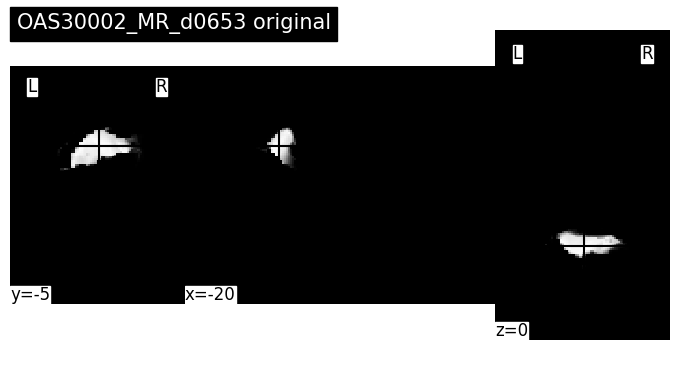

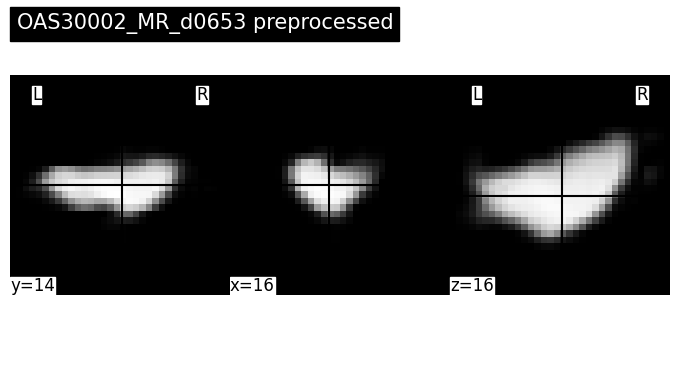

In [19]:
original_img, preproc_img, exp = pr.test_preprocessing(train_datasets['left'], 34)
p.processed_example_comparison_plot(original_img, preproc_img, exp)

## Execute Pre-processing

### Training set

In [21]:
pr.execute_pre_processing('train_freesurfers_preprocess', train_datasets, 34)

Processing left hippocampus:   0%|          | 0/816 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/816 [00:00<?, ?it/s]

### Validation set

In [22]:
pr.execute_pre_processing('validation_freesurfers_preprocess', validation_datasets, 34)

Processing left hippocampus:   0%|          | 0/155 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/155 [00:00<?, ?it/s]

### Test set

In [23]:
pr.execute_pre_processing('test_freesurfers_preprocess', test_datasets, 34)

Processing left hippocampus:   0%|          | 0/223 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/223 [00:00<?, ?it/s]

- Let's get a plot of a random pre-processed experiment to verify that data have been saved correctly

OAS30496_MR_d2304


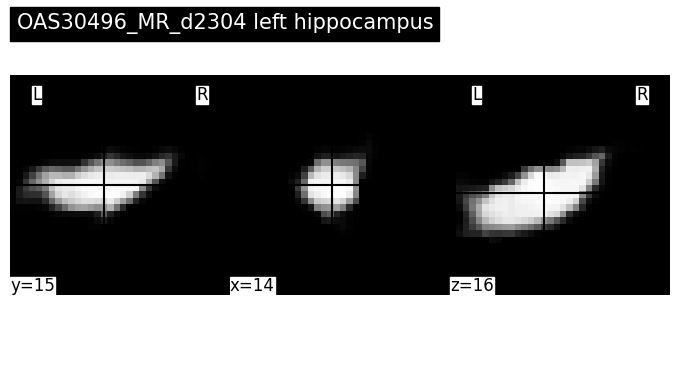

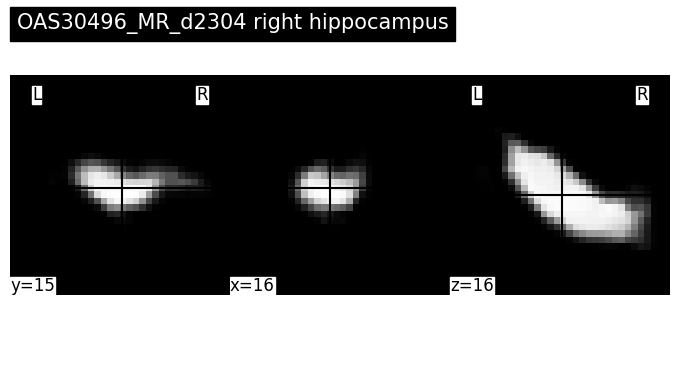

In [24]:
p.plot_img_by_experiment_id(
    dir=os.path.join('..', 'data', 'train_freesurfers_preprocess'),
    id=train_df['MR_session'].sample(n=1).to_list()[0]
)

## Train set augmentation
- In this section train and validation sets will be augmented with the operations defined in the previous notebook
- Let's load the training csv dataset where these additional instances are defined

In [25]:
full_train_set_df = pd.read_csv('../data/csv/train.csv')
full_val_set_df = pd.read_csv('../data/csv/validation.csv')

- Sort the instances and drop cognitevely normal patients from the train set

In [26]:
full_train_set_df = (
    full_train_set_df
        .drop(
            columns='Unnamed: 0', 
            index=full_train_set_df[full_train_set_df['label'] == 'Non-Demented'].index
        )
        .sort_values(by='MR_session')
        .reset_index(drop=True)
)

- Sort the instances and drop cognitevely normal patients from the validation set

In [27]:
full_val_set_df = (
    full_val_set_df
        .drop(
            columns='Unnamed: 0', 
            index=full_val_set_df[full_val_set_df['label'] == 'Non-Demented'].index
        )
        .sort_values(by='MR_session')
        .reset_index(drop=True)
)

- Drop instances that refer to NO augmentation

In [28]:
full_train_set_df = full_train_set_df.drop(index=full_train_set_df[full_train_set_df['augmentation'] == 'normal'].index)
full_val_set_df = full_val_set_df.drop(index=full_val_set_df[full_val_set_df['augmentation'] == 'normal'].index)

- Define sub-dataframe that will be the inpur for the pre-processing module

In [33]:
aug_mci_train_df = full_train_set_df[full_train_set_df['label'] == 'MCI']
aug_mci_val_df = full_val_set_df[full_val_set_df['label'] == 'MCI']

aug_dem_train_df = full_train_set_df[full_train_set_df['label'] == 'Demented']
aug_dem_val_df = full_val_set_df[full_val_set_df['label'] == 'Demented']

## Datasets definition for augmentation

- This section is dedicated in the definition of the datasets made with that instances that will be augmented

### MCI dataset

- Dataset with MCI instances from the training set to augment

In [30]:
aug_mci_train_datasets = pr.get_datasets(
    base_dir=base_dir_train, 
    experiments=aug_mci_train_df['MR_session'].to_list(),
    labels=aug_mci_train_df['label'].to_list(),
)

- Dataset with MCI instances from the validation set to augment

In [31]:
aug_mci_val_datasets = pr.get_datasets(
    base_dir=base_dir_val, 
    experiments=aug_mci_val_df['MR_session'].to_list(),
    labels=aug_mci_val_df['label'].to_list(),
)

#### Visualize a MCI augmentations example

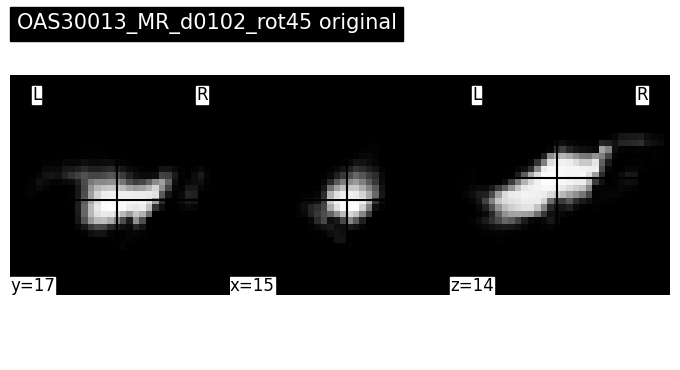

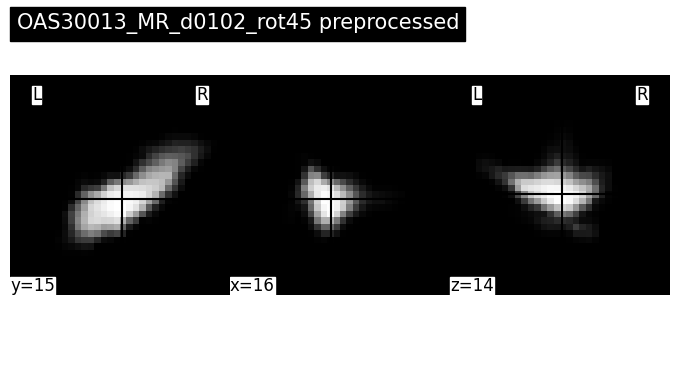

In [32]:
_, img_orig, exp = pr.test_preprocessing(aug_mci_train_datasets['left'], 34)
_, img_proc, exp = pr.test_preprocessing(aug_mci_train_datasets['left'], 34, [pr.operations.get_rotation(45)])

p.processed_example_comparison_plot(img_orig, img_proc, subject=exp)

### Demented dataset

- To augment the demented dataset we can't procede like MCI, since we have four different augmentation to perform
- To be consistent with the APIs of the `preprocessing` module we have to consider 4 different datasets, one for every different augmentation type (flip, rot30, rot90, ro150)
- We will produce 4 datasets for the demented instances in the train set and 4 datasets for the ones inside the validation set
- These datasets will be stored inside a list
- Let's start by taking the augmentation's types

In [42]:
dem_augs = full_train_set_df[full_train_set_df['label'] == 'Demented']['augmentation'].unique()
dem_augs

array(['flip', 'rot150', 'rot30', 'rot90'], dtype=object)

- Datasets with Demented instances from the training set to augment:
    1. Only instances to flip
    2. Only instances to rotate by 150 degrees
    3. Only instances to rotate by 30 degrees
    4. Only instances to rotate by 90 degrees

In [74]:
dem_train_datasets = [
    pr.get_datasets(
        base_dir=base_dir_train, 
        experiments=aug_dem_train_df[aug_dem_train_df['augmentation'] == aug]['MR_session'], 
        labels=aug_dem_train_df[aug_dem_train_df['augmentation'] == aug]['label']
    )
    for aug in dem_augs
]

- Create the same datasets for the validation set instances

In [75]:
dem_val_datasets = [
    pr.get_datasets(
        base_dir=base_dir_val, 
        experiments=aug_dem_val_df[aug_dem_val_df['augmentation'] == aug]['MR_session'], 
        labels=aug_dem_val_df[aug_dem_val_df['augmentation'] == aug]['label']
    )
    for aug in dem_augs
]

- Create a dictionary to improve the access of the datasets inside the lists created above

In [60]:
dem_data_indexer = {aug: i for i, aug in enumerate(dem_augs)}
dem_data_indexer

{'flip': 0, 'rot150': 1, 'rot30': 2, 'rot90': 3}

- Define the augmentation operations

In [80]:
dem_ops = {
    'flip': [pr.operations.FLIP],
    'rot150': [pr.operations.get_rotation(150)],
    'rot30': [pr.operations.get_rotation(30)],
    'rot90': [pr.operations.get_rotation(90)]
}

### Visualize the effect of a flip

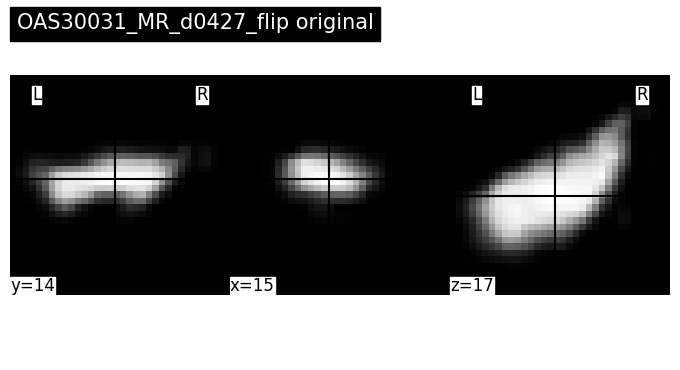

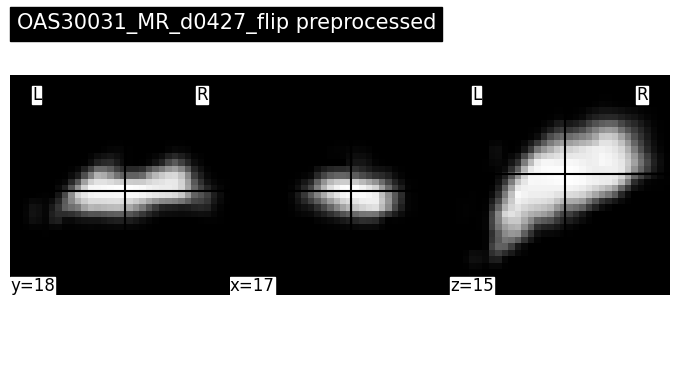

In [76]:
i = dem_data_indexer['flip']
_, img_orig, exp = pr.test_preprocessing(dem_train_datasets[i]['left'], 34)
_, img_proc, exp = pr.test_preprocessing(dem_train_datasets[i]['left'], 34, [pr.operations.FLIP])

p.processed_example_comparison_plot(img_orig, img_proc, subject=exp)

## Executing Augmentation

### Train set MCI data

In [67]:
pr.execute_pre_processing(
    save_dir_name='train_freesurfers_preprocess', 
    datasets=aug_mci_train_datasets, 
    spatial_size=34, 
    additional_operations=[pr.operations.get_rotation(45)]
)

Processing left hippocampus:   0%|          | 0/134 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/134 [00:00<?, ?it/s]

### Validation set MCI data

In [70]:
pr.execute_pre_processing(
    save_dir_name='validation_freesurfers_preprocess', 
    datasets=aug_mci_val_datasets, 
    spatial_size=34, 
    additional_operations=[pr.operations.get_rotation(45)]
)

Processing left hippocampus:   0%|          | 0/23 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/23 [00:00<?, ?it/s]

- Visualize the results of MCI augmentation

OAS30330_MR_d0000_rot45


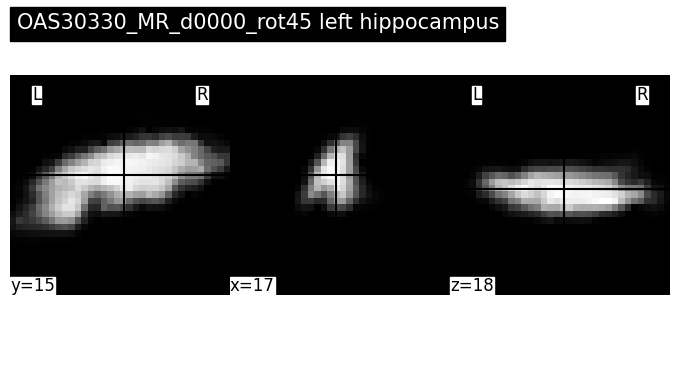

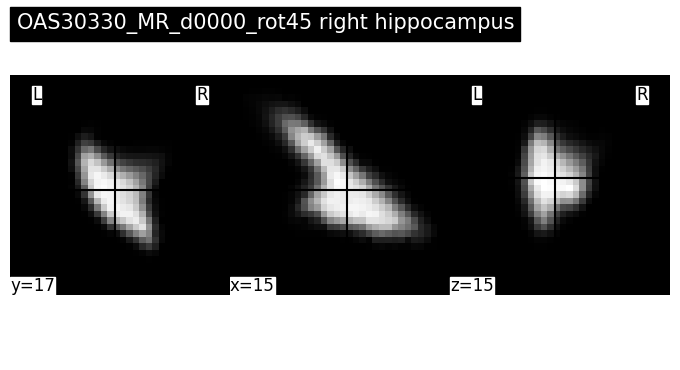

In [69]:
p.plot_img_by_experiment_id(
    dir=os.path.join('..', 'data', 'train_freesurfers_preprocess'),
    id=aug_mci_train_df['MR_session'].sample(n=1).to_list()[0]
)

### Train set demented data

In [81]:
for aug in dem_augs:
    pr.execute_pre_processing(
        save_dir_name='train_freesurfers_preprocess',
        datasets=dem_train_datasets[dem_data_indexer[aug]],
        spatial_size=34,
        additional_operations=dem_ops[aug]
    )

Processing left hippocampus:   0%|          | 0/61 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/61 [00:00<?, ?it/s]

Processing left hippocampus:   0%|          | 0/61 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/61 [00:00<?, ?it/s]

Processing left hippocampus:   0%|          | 0/61 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/61 [00:00<?, ?it/s]

Processing left hippocampus:   0%|          | 0/61 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/61 [00:00<?, ?it/s]

### Validation set demented data

In [82]:
for aug in dem_augs:
    pr.execute_pre_processing(
        save_dir_name='validation_freesurfers_preprocess',
        datasets=dem_val_datasets[dem_data_indexer[aug]],
        spatial_size=34,
        additional_operations=dem_ops[aug]
    )

Processing left hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing left hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing left hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing left hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

- Visualize a random result of demented augmentation

OAS31060_MR_d0083_rot30


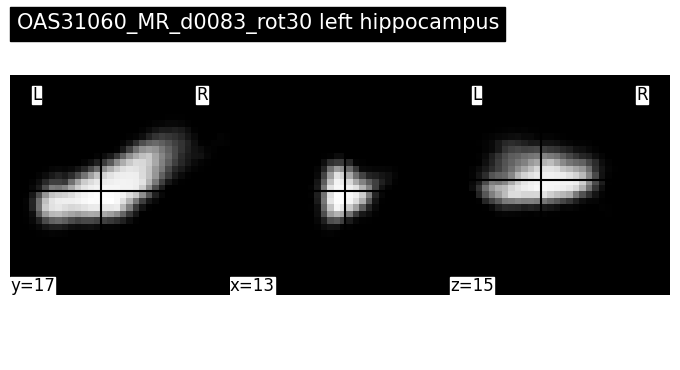

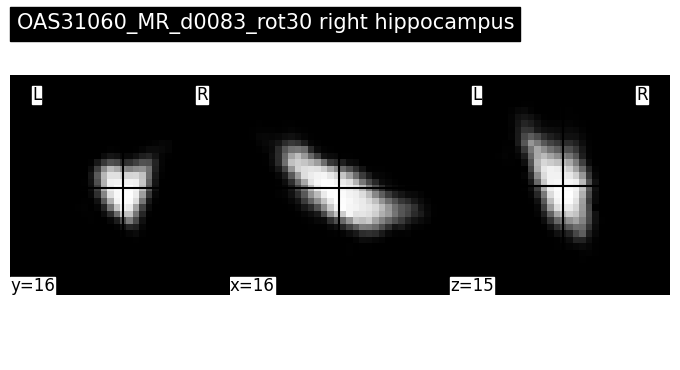

In [84]:
p.plot_img_by_experiment_id(
    dir=os.path.join('..', 'data', 'train_freesurfers_preprocess'),
    id=aug_dem_train_df['MR_session'].sample(n=1).to_list()[0]
)

In [95]:
df = pd.read_csv('../data/csv/test.csv')

In [96]:
len(os.listdir('../data/test_freesurfers_preprocess'))

223